<a href="https://colab.research.google.com/github/PulkitChaudhari/Binance-Python/blob/main/Binance_Python_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance
!pip install config
!pip install SQLAlchemy
!pip install pytz
import sqlalchemy
import pytz
from datetime import datetime
from pytz import timezone
import pandas as pd
from binance.client import Client
from binance import BinanceSocketManager

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
apiKey = ""
apiSecurity = ""

In [ ]:
client = Client(apiKey,apiSecurity)
print("Logged In")

Logged In


In [ ]:
bsm = BinanceSocketManager(client)  

In [ ]:
socket = bsm.trade_socket('BTCUSDT')

In [ ]:
engine = sqlalchemy.create_engine('sqlite:///BTCUSDTstream.db')

In [ ]:
def createFrame(msg):
  df = pd.DataFrame([msg])
  df = df.loc[:,['s','E','p']]
  df.columns = ['symbol','Time','Price']
  df.Price = df.Price.astype(float)
  df.Time = pd.to_datetime(df.Time,unit='ms')
  str = df.Time.to_string()
  str = str[4:-4]
  hehetemp = datetime.strptime(str,'%Y-%m-%d %H:%M:%S')
  df.Time = hehetemp.astimezone(pytz.timezone('Asia/Kolkata'))
  return df

In [ ]:
for i in range(0,3):
  await socket.__aenter__()
  msg = await socket.recv()
  frame = createFrame(msg)
  frame.to_sql('BTCUSDT',engine,if_exists='append',index=False)
  print(frame)

    symbol                      Time     Price
0  BTCUSDT 2022-11-03 22:15:31+05:30  20287.22
    symbol                      Time     Price
0  BTCUSDT 2022-11-03 22:15:31+05:30  20287.22
    symbol                      Time     Price
0  BTCUSDT 2022-11-03 22:15:31+05:30  20287.57


In [ ]:
df = pd.read_sql('BTCUSDT',engine)

In [ ]:
df

,symbol,Time,Price
0,BTCUSDT,2022-11-03 21:52:30,20258.70
1,BTCUSDT,2022-11-03 21:52:30,20258.94
2,BTCUSDT,2022-11-03 21:52:30,20258.72
3,BTCUSDT,2022-11-03 22:05:01,20262.67
4,BTCUSDT,2022-11-03 22:05:01,20262.36
5,BTCUSDT,2022-11-03 22:05:01,20263.44


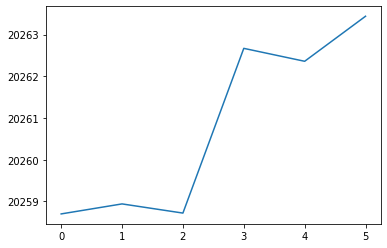

In [ ]:
df.Price.plot()

In [ ]:
def strategy(entry,lookback,qty,open_position=False):
  #entry defines the buying criteria for crypto
  #lookback defines the period for which we will go back in timestamps
  #open_position means if we have jumped onto the trade or not (inshort bought the asset)
  # this is a simple trading strategy which buys the coin if there is rise of entry% in price 
  # it closes the deal if there is a 0.15% profit or 0.15% loss
  while True:
    df = pd.read_sql('BTCUSDT',engine)
    lookbackperiod = df.iloc[-lookback:]
    cumret = (lookbackperiod.Price.pct_change()+1).cumprod()-1
    if not open_position:
      if cumret[cumret.last_valid_index()] > entry:
        order = client.create_order(symbol='BTCUSDT',side='BUY',type='MARKET',quantity=qty)
        print(order)
        open_position = True
        break
  if open_position:
    while True:
      df = pd.read_sql('BTCUSDT',engine)
      sincebuy = df.loc[df.Time > pd.to_datetime(order['transactTime'],unit='ms')]
      if len(sincebuy) > 1:
        sincebuyret = (sincebuy.Price.pct_change() + 1).cumprod()-1
        last_entry = sincebuyret[sincebuyret.last_valid_index()]
        if last_entry > 0.0015 or last_entry < 0.0015:
          order = client.create_order(symbol='BTCUSDT',side='SELL',type='MARKET',quantity=qty)
          print(order)
          break

In [ ]:
#strategy(0.001,60,0.001)

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f731fc1c680>
Traceback (most recent call last):
  File "/usr/lib/python3.7/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt


KeyboardInterrupt: ignored